In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [3]:
training_data = datasets.FashionMNIST(
    root='data',
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

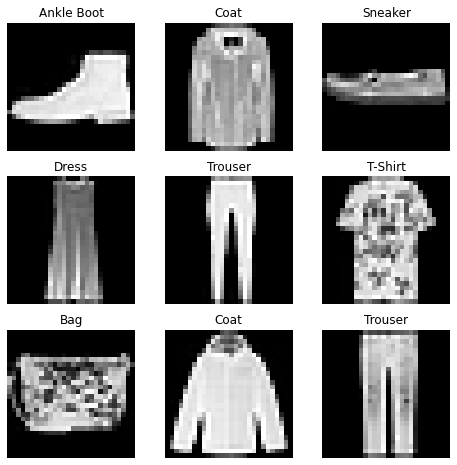

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
    idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [5]:
import pandas as pd
from torchvision.io import read_image

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform(image):
            label = self.target_transform(label)
        return image, label

In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [8]:
from torchvision.transforms import Lambda

In [9]:
ds = datasets.FashionMNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

In [10]:
from torch import nn

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Use {device}')

Use cpu


In [12]:
class NetWork(nn.Module):
    def __init__(self):
        super(NetWork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [13]:
model = NetWork().to(device)
print(model)

NetWork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [14]:
X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred = nn.Softmax(dim=1)(logits)
y_pred = pred.argmax(1)
print(f'Predicted class: {y_pred}')

Predicted class: tensor([6])


In [15]:
learning_rate = 1e-3
batch_size = 64

In [16]:
loss_fn = nn.CrossEntropyLoss()

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [18]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f} | {current:>5d}/{size:>5d}')

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
        test_loss /= num_batches
        correct /= size
        print(f'test error: \n Accuracy: {100*correct:>0.1f}%, Avg loss: {test_loss:>8f} \n')

In [19]:
epochs = 10
for t in range(epochs):
    print(f'Epoch {t+1}\n---------------------------------')
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print('Done')

Epoch 1
---------------------------------
loss: 2.291433 |     0/60000
loss: 2.288927 |  6400/60000
loss: 2.279929 | 12800/60000
loss: 2.258233 | 19200/60000
loss: 2.247730 | 25600/60000
loss: 2.231617 | 32000/60000
loss: 2.228833 | 38400/60000
loss: 2.204798 | 44800/60000
loss: 2.174213 | 51200/60000
loss: 2.164961 | 57600/60000
test error: 
 Accuracy: 48.1%, Avg loss: 2.150957 

Epoch 2
---------------------------------
loss: 2.149506 |     0/60000
loss: 2.129232 |  6400/60000
loss: 2.104597 | 12800/60000
loss: 2.099527 | 19200/60000
loss: 2.043657 | 25600/60000
loss: 2.010389 | 32000/60000
loss: 1.986776 | 38400/60000
loss: 1.929208 | 44800/60000
loss: 1.931684 | 51200/60000
loss: 1.921016 | 57600/60000
test error: 
 Accuracy: 59.6%, Avg loss: 1.880713 

Epoch 3
---------------------------------
loss: 1.860368 |     0/60000
loss: 1.851908 |  6400/60000
loss: 1.823517 | 12800/60000
loss: 1.734463 | 19200/60000
loss: 1.733403 | 25600/60000
loss: 1.641985 | 32000/60000
loss: 1.727032 |

In [20]:
model.eval()

NetWork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [21]:
T, F = 0, 0
for i in range(2, 43):
    pred = model(training_data[i][0])
    y_pred = int(pred.argmax(1)[0])
    print(f'Prediction: {labels_map[y_pred]} | Real label: {labels_map[training_data[i][1]]}')
    if labels_map[y_pred] == labels_map[training_data[i][1]]:
        T += 1
    else:
        F += 1
print(str(round(T / (T+F) * 100, 2)) + '%')

Prediction: Trouser | Real label: T-Shirt
Prediction: T-Shirt | Real label: Dress
Prediction: Dress | Real label: T-Shirt
Prediction: Pullover | Real label: Pullover
Prediction: Sneaker | Real label: Sneaker
Prediction: Pullover | Real label: Pullover
Prediction: Ankle Boot | Real label: Sandal
Prediction: Ankle Boot | Real label: Sandal
Prediction: T-Shirt | Real label: T-Shirt
Prediction: Ankle Boot | Real label: Ankle Boot
Prediction: Sandal | Real label: Sandal
Prediction: Sneaker | Real label: Sandal
Prediction: Sneaker | Real label: Sneaker
Prediction: Ankle Boot | Real label: Ankle Boot
Prediction: Trouser | Real label: Trouser
Prediction: T-Shirt | Real label: T-Shirt
Prediction: Pullover | Real label: Shirt
Prediction: Coat | Real label: Coat
Prediction: Dress | Real label: Dress
Prediction: Trouser | Real label: Trouser
Prediction: Coat | Real label: Coat
Prediction: Bag | Real label: Bag
Prediction: Coat | Real label: Coat
Prediction: Dress | Real label: Dress
Prediction: T-